# Baseline Model (Non-Repeat Donors)

### Imports

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

from config import DATA_DIR

### Preprocessing

In [2]:
# Load dataset_non_repeat.csv as a pandas dataframe
df = pd.read_csv(os.path.join(DATA_DIR, 'dataset_non_repeat.csv'))

# Drop columns
df = df.drop(['transaction.id', 'date', 'bonica.cid', 'bonica.rid', 'repeat_donor', 'adjusted_amount', 'recipient.name'], axis=1)

print(df.shape)
print(df['cycle'].max())
df.head()

(24708, 83)
1998


/tmp/ipykernel_26957/1545277390.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_DIR, 'dataset_non_repeat.csv'))


,cycle,amount,contributor.zipcode,recipient.party,recipient.type,recipient.state,seat,election.type,latitude,longitude,...,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
0,1980,500.0,14224,100,CAND,NY,federal:house,G,42.837490,-78.750832,...,0,0,0,0,0,0,0,0,0,0
1,1980,1000.0,77027,100,CAND,LA,federal:senate,P,29.740080,-95.446411,...,0,1,0,0,0,0,0,0,0,0
2,1980,500.0,70806,100,CAND,LA,federal:senate,P,30.474125,-91.110931,...,0,0,0,0,0,0,0,0,0,0
3,1980,250.0,70005,100,CAND,LA,federal:senate,P,29.998821,-90.134430,...,0,0,0,0,0,0,0,0,0,0
4,1980,1000.0,71106,100,CAND,LA,federal:senate,P,32.391171,-93.711609,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Set the target variable to be the amount of the donation
y = df['amount']

# Set the features to be the rest of the columns
X = df.drop('amount', axis=1)

# Converting categorical variables to dummy variables
X = pd.get_dummies(X)

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Print the shapes of the training and testing sets
print(X_train_imputed.shape, X_test_imputed.shape, y_train.shape, y_test.shape)


(19766, 190) (4942, 190) (19766,) (4942,)


### Modeling

In [5]:
# Initialize the Lasso Regression model 
lasso = Lasso(alpha=0.01, random_state=109) 

# Train the model
lasso.fit(X_train_imputed, y_train)


/home/daniel/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.814e+09, tolerance: 1.340e+06
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01, random_state=109)

In [6]:
# Predict on the test data
y_pred = lasso.predict(X_test_imputed)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error of Baseline Model:', mae)

# Compare MAE of model to MAE of a model that predicts the mean of the response variable
mean = np.mean(y_train)
y_pred_mean = np.full(y_test.shape, mean)
mae_baseline = mean_absolute_error(y_test, y_pred_mean)
print('Mean Absolute Error of Naive Model:', mae_baseline)


Mean Absolute Error of Baseline Model: 225.29988044198504
Mean Absolute Error of Naive Model: 318.0841786348682


### Visualizations

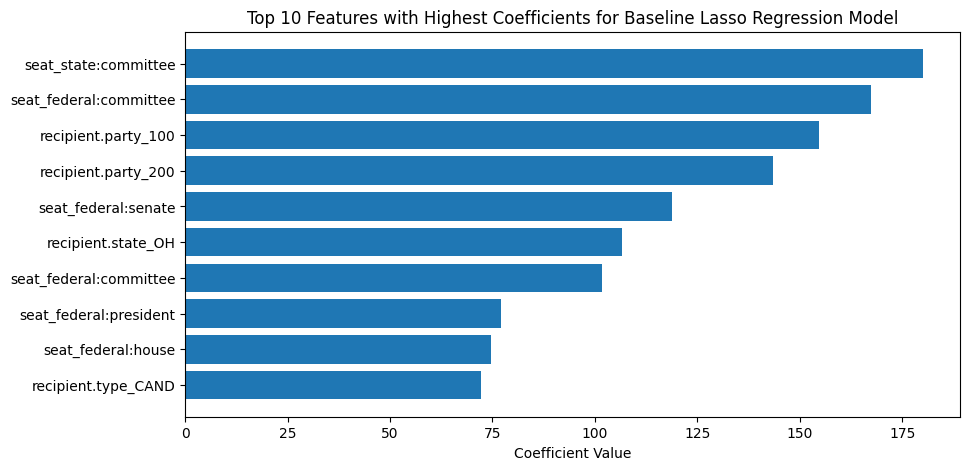

In [7]:
# Visualize the top n features with the highest coefficients
n = 10
features = X.columns
importances = lasso.coef_
indices = np.argsort(importances)[-n:]
plt.figure(figsize=(10, 5))
plt.title(f'Top {n} Features with Highest Coefficients for Baseline Lasso Regression Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Coefficient Value')
plt.show()



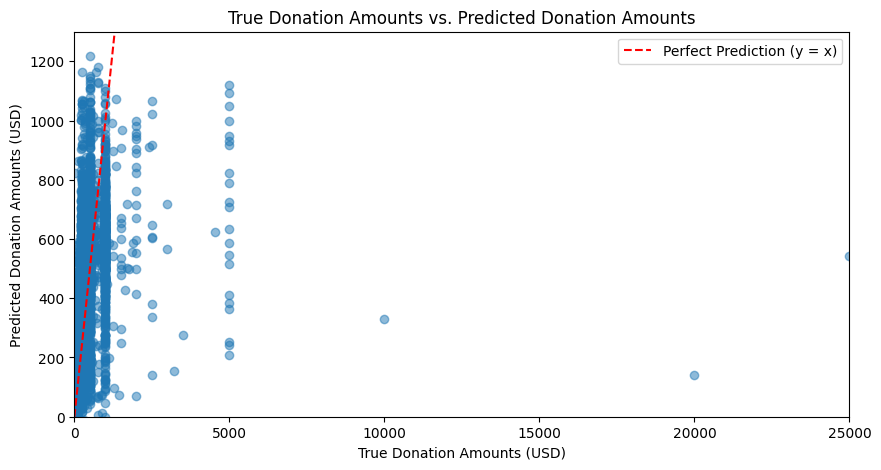

In [8]:
# Plot the predicted values against the true values,
# with line for predicted = true for reference.
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)

# Add the line y = x
line_range = np.linspace(0, 1300, 100)  # Use 0 to 1300 for y = x line
plt.plot(line_range, line_range, 'r--', label='Perfect Prediction (y = x)')  # Plotting the line y = x in red dashed format

# Setting axes limits
plt.xlim([0, 25000])  # Limit the x-axis to 25000
plt.ylim([0, 1300])   # Limit the y-axis to 1300

# Adding labels and title
plt.xlabel('True Donation Amounts (USD)')
plt.ylabel('Predicted Donation Amounts (USD)')
plt.title('True Donation Amounts vs. Predicted Donation Amounts')

plt.legend()

# Display the plot
plt.show()

This model is fairly effective at predicting small-dollar donations of first-time donors, most predictions are concentrated around the predicted=actual line. However, it vastly under-estimates donations over $5000 in value. This is to be expected, given that the vast majority of individual donors do not donate such large sums of money, according to the eda.ipynb notebook, so it is difficult to accurately estimate them.

For an analysis of repeat donors, see preprocess_and_RNN.ipynb